In [380]:
import numpy as np
import pandas as pd
import seaborn as sb
sb.set_style("dark")
import matplotlib.pyplot as plt
import time

### 5 days left before you have to send pre-read materials 

#### TODO:
- convert to binary problem. plant veg v in bed b yes or no
    - still have:
        - sun constraint
        - companion planting constraint
        - yoy planting constraint
    - removes (simplfies):
        - bed packing sub-problem because we can ignore capacity questions in this scenario
        

- rewriting sun constraint could cut your run time in half
- consider swapping out algorithm

- add capacity constraint (may end up being a separate bin packing problem. potentially leverage parallel processing for this and just implement a greedy approach here)
- potentially add objective limit the number of unique plants in each bed
- add to bed info the list of incompatable plants in that bed
- consider changing wording of plant to vegetable or veg or produce or crop or provision
- look into parallel processing. potentially have notebook run in AWS
- potential convert to class
- look into random seed best practices
- fill in documentation to make this easier to walk through during the workshop
- formulate and implement a MIP to solve the same problem
- figure out some good pre-read materials
- visualize solution space
- visualizations at the end
- add gif showing simulated annealing
- email chris this notebook and let him decide if we should do both 

In [381]:
plant_info = pd.read_csv('../data/plant_data.csv')
bed_info = pd.read_csv('../data/bed_data.csv')

In [382]:
plant_info.index.name = 'plant_index'
plants = plant_info.plant.to_numpy()
plant_index = plant_info.index.to_numpy()
num_plants = len(plants)

In [383]:
bed_info.index.name = 'bed_index'
beds = bed_info.bed.to_numpy()
bed_index = bed_info.index.to_numpy()
num_beds = len(beds)

#for keeping track of what axis is which
bed_axis = 0
plant_axis = 1

bed_width = 3
bed_length = 10
bed_capacity = bed_length*12

In [384]:
print(num_beds)
print(beds)
print(bed_index)

42
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]


In [385]:
#average preference
family = ['evan','gina','liesse','lizzie','jack']
plant_info['avg_pref'] = np.average(plant_info[family],axis=1,weights=[.5,.5,0,0,0])
plant_info.drop(family,axis=1,inplace=True)
preferences = plant_info.avg_pref.to_numpy()
plant_index_by_pref = plant_info.sort_values('avg_pref',ascending=False).index 

plant_spacing = plant_info.plant_spacing.to_numpy()

In [386]:
#get plant and bed sun requirements
plant_sun_req = plant_info.sun.to_numpy()
bed_sun_req = bed_info.sun.to_numpy()

In [387]:
weights = {'yield_': 1,}
        #    'yummy_score': 0.98,
        #    'variety_score': 0.01}

In [388]:
plant_info.sort_values('avg_pref',ascending=False).iloc[0].name

2

In [389]:
#most preferred 
max_pref = plant_info.sort_values('avg_pref',ascending=False).iloc[0].name

In [390]:
#convert info dfs to dicts
# plant_info = plant_info.to_dict(orient='index')
# bed_info = bed_info.to_dict(orient='index')

In [391]:
#initialize plan. no plants in any bed
np.random.seed(2134)
initial_plan = np.random.randint(0,10,size=(num_beds,num_plants))
print(initial_plan)

[[4 9 1 ... 0 4 1]
 [5 3 0 ... 1 5 2]
 [1 8 1 ... 6 0 0]
 ...
 [1 7 4 ... 5 1 5]
 [0 6 5 ... 6 9 0]
 [7 9 6 ... 7 6 5]]


In [392]:
def make_neighbor(plan,iteration,cycle_size=5000):
    """
    iteration: 
    cycle_size: 
    """
    #pick a random bed
    bed = np.random.choice(bed_index)
    #pick a random plant
    plant = np.random.choice(plant_index)
    #decide whether to plant another plant in bed or remove one
    prob_add = (iteration%cycle_size)/cycle_size
    decision = np.random.choice([1,-1],p=[prob_add,1-prob_add])

    #make a decision
    new_plan = plan.copy()
    new_plan[bed][plant] = max(0,new_plan[bed][plant] + decision) #max(0,n) takes care of case of negative planting

    return new_plan

In [393]:
def sun_constraint(plan,bed_sun_req,plant_sun_req):
    """
    Scans beds and plants, kills any plant that is in a bed that does not match its sun requirement.
    """
    plan_sun = plan.copy()
    for b in bed_index:
        for p in plant_index:
            b_sun = bed_sun_req[b]
            p_sun = plant_sun_req[p]
            if b_sun != p_sun:
                plan_sun[b][p] = 0
    return plan_sun

In [394]:
# def bed_packing(bed,plan,plant_index_by_pref,plant_spacing):
#     """
#     Handles the fact that the plan doesn't account for the spacing constraints required in 
#     each bed. Plan is likely over planting inside of each bed. Each bed is now a separate 
#     bin packing problem. This function applies a greedy heuristic for updating a plan to 
#     prioritize planting most preferred plants until you run out of space. Not necessarily 
#     optimal because you could improve the objective by planting less preferred plants that 
#     require less space.    
#     """
#     plan_beds_finalized = plan.copy()
#     remaining_capacity = bed_capacity

#     for plant in plant_index_by_pref:
#         if remaining_capacity>0:
#             spacing = plant_spacing[plant]
#             num_plants_planned = plan[bed][plant]
#             num_plant_capacity = remaining_capacity/spacing
#             plants_planted = min(num_plants_planned,num_plant_capacity) #ensures I don't exceed capacity
#             plan_beds_finalized[bed][plant] = plants_planted
#             remaining_capacity -= plants_planted*spacing
#         else:
#             plan_beds_finalized[bed][plant] = 0 #once I run out of capacity, update plan to plant 0       
    
    
#     return plan_beds_finalized

In [395]:
def bed_packing(bed,plan,plant_index_by_pref,plant_spacing):
    """
    Handles the fact that the plan doesn't account for the spacing constraints required in each bed. Plan is likely 
    over planting inside of each bed. Each bed is now a separate bin packing problem. This function applies a greedy 
    heuristic for updating a plan to prioritize planting most preferred plants until you run out of space. Not
    necessarily optimal because you could improve the objective by planting less preferred plants that require less space.    
    """
    plan_beds_finalized = plan.copy()

    plant_capacity_req = plant_spacing*plan_beds_finalized[bed] #capacity required by individual plants in the plan
    plant_capacity_req = plant_capacity_req[plant_index_by_pref] #sort capacities so that most preferred plant is first (least preferred is last)

    cumulative_capacity_req = plant_capacity_req.cumsum() #get the cumulative sum of plant capacity used after planting most to least preferred plants
    sufficient_capacity = cumulative_capacity_req <= bed_capacity #mask, False at the point where no longer capacity to plant
    capacity_used = np.max(cumulative_capacity_req*sufficient_capacity)#actual total capacity used 

    #for topping off bed if there is leftover capacity
    cutoff_plant_idx = sufficient_capacity.argmin()#get the index of the first plant for which there was not sufficient capacity
    cutoff_plant = plant_index_by_pref[cutoff_plant_idx]#id of the cutoff plant

    sufficient_capacity = sufficient_capacity[plant_index_by_pref.argsort()] #re-sort excess capacity by plant index so they are in the right order
    plan_beds_finalized[bed] *= sufficient_capacity #keep plants with sufficient capacity (*1) set plants that don't fit to 0 (*0)

    plan_beds_finalized[bed][cutoff_plant] = np.floor((bed_capacity-capacity_used)/plant_spacing[cutoff_plant])#add as much of the cutoff plant as there is remaining capacity for
    return plan_beds_finalized

In [396]:
#number of inches required between plants for each veg
plant_spacing

array([ 4.  , 12.  , 24.  ,  6.  , 18.  , 48.  , 18.  , 18.  , 24.  ,
       12.  ,  1.  , 24.  , 12.  ,  2.  ,  0.25, 12.  ,  0.25, 18.  ,
       18.  , 24.  , 18.  ,  6.  , 12.  , 12.  , 12.  ,  8.  , 12.  ,
       36.  , 28.  , 24.  , 18.  , 12.  ,  6.  ,  6.  ,  3.  , 18.  ])

In [397]:
#plan for bed 1
initial_plan[1]

array([5, 3, 0, 1, 1, 2, 2, 2, 0, 7, 5, 8, 2, 6, 3, 3, 6, 4, 5, 9, 4, 5,
       4, 7, 0, 5, 6, 0, 3, 1, 0, 2, 4, 1, 5, 2])

In [398]:
#total number of inches required to implement plan for bed 1 per veg
plant_capacity_req = plant_spacing*initial_plan[1]
plant_capacity_req

array([ 20.  ,  36.  ,   0.  ,   6.  ,  18.  ,  96.  ,  36.  ,  36.  ,
         0.  ,  84.  ,   5.  , 192.  ,  24.  ,  12.  ,   0.75,  36.  ,
         1.5 ,  72.  ,  90.  , 216.  ,  72.  ,  30.  ,  48.  ,  84.  ,
         0.  ,  40.  ,  72.  ,   0.  ,  84.  ,  24.  ,   0.  ,  24.  ,
        24.  ,   6.  ,  15.  ,  36.  ])

In [399]:
#sort capacity requirements by most preferred veg to least preferred
plant_capacity_req = plant_capacity_req[plant_index_by_pref]
plant_capacity_req

array([  0.  ,  36.  , 192.  ,  84.  ,  24.  ,  84.  ,   1.5 ,   0.  ,
        36.  ,   0.  ,  24.  ,  24.  ,   5.  ,  30.  ,  15.  ,  36.  ,
        96.  ,  18.  ,   0.  ,  40.  ,  72.  ,  90.  , 216.  ,   6.  ,
        72.  ,  24.  ,  84.  ,  72.  ,  36.  ,  36.  ,  48.  ,   0.75,
         0.  ,   6.  ,  20.  ,  12.  ])

In [400]:
# get the cumulative sum of plant capacity used after planting most to least preferred plants
cumulative_capacity_req = plant_capacity_req.cumsum() 
cumulative_capacity_req

array([   0.  ,   36.  ,  228.  ,  312.  ,  336.  ,  420.  ,  421.5 ,
        421.5 ,  457.5 ,  457.5 ,  481.5 ,  505.5 ,  510.5 ,  540.5 ,
        555.5 ,  591.5 ,  687.5 ,  705.5 ,  705.5 ,  745.5 ,  817.5 ,
        907.5 , 1123.5 , 1129.5 , 1201.5 , 1225.5 , 1309.5 , 1381.5 ,
       1417.5 , 1453.5 , 1501.5 , 1502.25, 1502.25, 1508.25, 1528.25,
       1540.25])

In [401]:
# mask, False at the point where no longer capacity to plant
sufficient_capacity = cumulative_capacity_req <= bed_capacity
sufficient_capacity

array([ True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [402]:
#total capacity we would use to fit plants with sufficient capacity
capacity_used = np.max(cumulative_capacity_req*sufficient_capacity)
capacity_used

36.0

In [403]:
cutoff_plant_idx = sufficient_capacity.argmin()#get the index of the first plant for which there was not sufficient capacity
cutoff_plant = plant_index_by_pref[cutoff_plant_idx]#id of the cutoff plant

print(cutoff_plant_idx)
print(cutoff_plant,f"({plant_info.iloc[cutoff_plant]['plant']})")
print(f'original plan for cuttoff plant: {initial_plan[1][cutoff_plant]}')

2
11 (Cayene peppers)
original plan for cuttoff plant: 8


In [404]:
#re-sort excess capacity by plant index so they are in the original plant idx order
sufficient_capacity = sufficient_capacity[plant_index_by_pref.argsort()] 
sufficient_capacity

array([False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [405]:
#keep plants with sufficient capacity (*1) set plants that don't fit to 0 (*0)
print(initial_plan[1])
initial_plan[1] *= sufficient_capacity 
print(initial_plan[1])    

[5 3 0 1 1 2 2 2 0 7 5 8 2 6 3 3 6 4 5 9 4 5 4 7 0 5 6 0 3 1 0 2 4 1 5 2]
[0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [406]:
#add as much of the cutoff plant as there is remaining capacity for
initial_plan[1][cutoff_plant] = np.floor((bed_capacity-capacity_used)/plant_spacing[cutoff_plant])
print(initial_plan[1])

[0 3 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [407]:
for bed in bed_index: #this loop would be taken out if paralelizing this
    initial_plan = bed_packing(bed,initial_plan,plant_index_by_pref,plant_spacing)

In [408]:
def compute_yield(plan):
    """
    Yield is the % of plants that are planted and survive. Not all plants will survive where they are planted.
    This is where we impose constraints on sun requirements, year-over-year planting requirements, and companion planting requirements.
    Returns the total number of surviving plants / the total plants planted.
    """
    # 
    #Too little/too much sun can kill certain plants
    #Some plants don't do well depending on what was planted the year before
    #Some plants don't go well next to each other
    #denominator. total number of plants planted
    total_plants_planted = plan.sum()  
    
    plan_yield = plan.copy()

    #impose constraints that kill plants in beds where they are not supposed to be
    # plan_yield = sun_constraint(plan_yield,bed_sun_req,plant_sun_req)

    #loop through beds and solve sub-problems
    for bed in bed_index: #this loop would be taken out if paralelizing this
        plan_yield = bed_packing(bed,plan_yield,plant_index_by_pref,plant_spacing)
        
    # plan = yoy_planting_constraint(plan)
    # plan = companion_planting_constraint(plan)
    return (plan_yield.sum()/total_plants_planted)*100

def compute_yummy_score(plan,preferences):
    """Takes the weighted average of the preferences of each plant, weighted by the total qty of plants 
    in the current plan for each plant. Maximization encourages plants with higher preferences to be planted in higher quantities."""
    plan_yummy = plan.copy()
    plan_by_plant = plan_yummy.sum(axis=bed_axis)
    yums = np.average(preferences,weights=plan_by_plant)*10
    return yums

def compute_variety_score(plan,num_plants):
    """Sums the number of unique plants that are actually planted in the garden. Counts the number of plants that are being planted across all beds.
       Then counts the number of plants with non-zero planting plan. 
       Maximization encourages more unique plants to be planted."""
    plan_variety = plan.copy()
    variety_score = (plan_variety.sum(axis=bed_axis) > 0).sum()/num_plants*100
    return variety_score

In [409]:
def get_objective(plan,weights,initial_obj_values):
    yield_ = compute_yield(plan)
    # yummy_score = compute_yummy_score(plan,preferences)
    # variety_score = compute_variety_score(plan,num_plants)
    objective = (
                (weights['yield_']*yield_) / initial_obj_values['yield_']
              # + (weights['yummy_score']*yummy_score) / initial_obj_values['yummy_score'] 
              # + (weights['variety_score']*variety_score) / initial_obj_values['variety_score']
                )
    return (objective,{'objective':objective,'yield_':yield_})
        # return (objective,{'objective':objective,'yield_':yield_,'yummy_score':yummy_score,'variety_score':variety_score})

In [410]:
def optimize(initial_plan,weights,starting_temperature=10000,alpha=0.99,max_SA_iter=10000,max_hone_iter=1000):
    
    initial_obj_values = {'yield_': compute_yield(initial_plan),
                          'yummy_score': compute_yummy_score(initial_plan,preferences),
                          'variety_score': compute_variety_score(initial_plan,num_plants)}

    current_plan = initial_plan.copy()
    current_objective,current_obj_values = get_objective(initial_plan,weights,initial_obj_values)
    
    best_plan = initial_plan.copy()
    best_objective = current_objective

    current_plan_obj_values = [(0,current_obj_values)]
    best_obj_values = [(0,current_obj_values)]
    total_planted = [(0,initial_plan.sum())]
    
    temperature = starting_temperature

    for i in range(max_SA_iter):
        # start = time.time()
        new_plan = make_neighbor(current_plan,i)
        # print('1:',(time.time()-start)*1000)
        # start = time.time()

        # print('2:',(time.time()-start)*1000)
        # start = time.time()
        new_objective,new_obj_values = get_objective(new_plan,weights,initial_obj_values)
        
        if new_objective > current_objective or np.exp(-(new_objective - current_objective)/temperature) > np.random.uniform():
            current_plan = new_plan.copy()
            current_objective = new_objective
            current_plan_obj_values.append((i,new_obj_values))
            total_planted.append((i,current_plan.sum()))
            
        # print('3:',(time.time()-start)*1000)
        # start = time.time()
        if new_objective > best_objective:
            best_plan = new_plan.copy()
            best_objective = new_objective
            best_obj_values.append((i,new_obj_values))      
        # print('4:',(time.time()-start)*1000)
        # start = time.time()
        #lower the temperature
        temperature *= temperature*alpha
        

    #add step to hone the best found solution after SA is complete (only accept improvement)
    # for i in range(max_hone_iter):
    #     new_plan = make_neighbor(best_plan,i)

    #     new_objective,new_obj_values = get_objective(new_plan,weights,initial_obj_values)
    
    #     if new_objective > best_objective:
    #         best_plan = new_plan.copy()
    #         best_objective = new_objective
    #         best_obj_values.append((i,new_obj_values))
        
    
    return best_plan,best_objective,best_obj_values,current_plan_obj_values,total_planted

In [411]:
best_plan,best_objective,best_obj_values,current_plan_obj_values,total_planted = optimize(initial_plan,weights,max_SA_iter=10000,max_hone_iter=1000)

In [412]:
best_obj_values[-1][1]

{'objective': 1.7642627981587389, 'yield_': 76.11940298507463}

In [413]:
objectives = []
yields = []
yummy_scores = []
variety_scores = []
total_plants = []
for i in current_plan_obj_values:
    objectives.append(i[1]['objective'])
    yields.append(i[1]['yield_'])
    # yummy_scores.append(i[1]['yummy_score'])
    # variety_scores.append(i[1]['variety_score'])

for i in total_planted:
    total_plants.append(i[1])

df = pd.DataFrame([objectives,yields,total_plants]).T#,yummy_scores,variety_scores]).T
df.columns = ['objective','yield_','total_plants']#,'yummy_score','variety_score']
df.reset_index(inplace=True)
df = df.melt(id_vars=['index','objective','total_plants'])

In [414]:
df[df.variable=='yield_'].value.max()

76.11940298507463

In [415]:
weights

{'yield_': 1}

In [416]:
df

,index,objective,total_plants,variable,value
0,0,1.000000,248.0,yield_,43.145161
1,1,1.000000,248.0,yield_,43.145161
2,2,1.000000,248.0,yield_,43.145161
3,3,1.000000,248.0,yield_,43.145161
4,4,1.000000,248.0,yield_,43.145161
...,...,...,...,...,...
9996,9996,0.177896,3179.0,yield_,7.675370
9997,9997,0.177840,3180.0,yield_,7.672956
9998,9998,0.177785,3181.0,yield_,7.670544
9999,9999,0.177729,3182.0,yield_,7.668133


In [418]:
42*36

1512

<AxesSubplot:xlabel='index', ylabel='total_plants'>

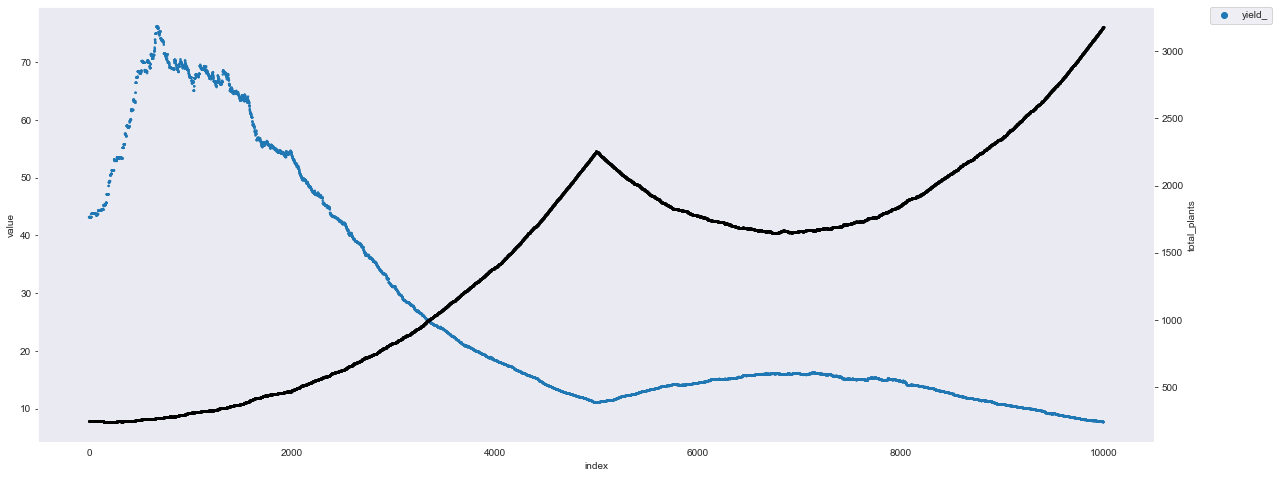

In [417]:
fig, ax = plt.subplots(figsize=(20,8))
sb.scatterplot(data=df,x='index',y='value',hue='variable',edgecolor=None,s=5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

ax2 = plt.twinx()
sb.scatterplot(data=df.drop_duplicates(['index','total_plants']),x='index',y='total_plants',edgecolor=None,ax=ax2,color='black',s=5)